In [1]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

from skimage import feature
from scipy import stats, ndimage

import photutils

from astropy import units as u
from astropy import stats
from astropy import visualization
from astropy import coordinates
from astropy.table import Table, vstack
from astropy.io import ascii, fits
from astropy.modeling import models, fitting, custom_model

In [14]:
def cart2pol(arr):
    """
    convert array of [x, y] vectors to [rho, theta]
    """
    x = arr[0]
    y = arr[1]
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return np.array([rho, theta])

def pol2cart(arr):
    """
    convert array of [rho, theta] vectors to [x, y]
    """
    rho = arr[0]
    theta = arr[1]
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return np.array([x, y])

def mk_pupil_model(size=400):
    """
    Use photutils to make an annular mask to use as a model for what a pupil should look like. 
    Arguments
    ---------
    size: int
        Image size in pixels (size x size)
        
    Returns
    -------
    mask:  2D np.ndarray
        Mask containing annular pupil model
    """
    annulus = np.zeros((size, size))
    # this mask will be 1 inside the annulus, 0 outside, and interpolated in pixels that are partially overlapped
    outer = photutils.geometry.circular_overlap_grid(-size/2., size/2., -size/2., size/2., size, size, 175, use_exact=0, subpixels=5)
    inner = photutils.geometry.circular_overlap_grid(-size/2., size/2., -size/2., size/2., size, size, 40, use_exact=0, subpixels=5)
    mask = annulus + outer - inner
    return mask

def plot_wfsfind(data, sources, ap_radius=5.0):
    positions = (sources['xcentroid'], sources['ycentroid'])
    apertures = photutils.CircularAperture(positions, r=ap_radius)
    norm = visualization.mpl_normalize.ImageNormalize(stretch=visualization.SqrtStretch())
    plt.imshow(data, cmap='gray', origin='lower', norm=norm, interpolation='None')
    apertures.plot(color='red', lw=1.5, alpha=0.5)

def wfsfind(data, fwhm=5.0, threshold=7.0, plot=False, ap_radius=5.0):
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    mean, median, std = stats.sigma_clipped_stats(data, sigma=3.0, iters=5)
    daofind = photutils.DAOStarFinder(fwhm=fwhm, threshold=threshold*std)
    sources = daofind(data - median)
    if plot:
        plot_wfsfind(data, sources, ap_radius=ap_radius)
    return sources

def get_spacing(data):
    """
    Measure the WFS grid spacing which changes with telescope focus.
    
    Arguments
    ---------
    data: str or 2D ndarray
        WFS data to analyze
        
    Returns
    -------
    xspacing, yspacing: float, float
        Average grid spacing in X and Y axes
    """
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    # sum along the axes and use Lomb-Scargle to measure the grid spacing in each direction
    xsum = np.sum(data, axis=0)
    ysum = np.sum(data, axis=1)
    x = np.arange(len(xsum))
    y = np.arange(len(ysum))
    k = np.linspace(5.0, 50., 1000.)  # look for spacings from 5 to 50 pixels (plenty of range)
    f = 1.0 / k  # convert spacing to frequency
    xp = stats.LombScargle(x, xsum).power(f)
    yp = stats.LombScargle(y, ysum).power(f) 
    # the peak of the power spectrum will coincide with the average spacing
    xspacing = k[xp.argmax()]
    yspacing = k[yp.argmax()]
    return xspacing, yspacing

def mk_reference(data, xoffset=0, yoffset=0, plot=False, pup_inner=40., pup_outer=175.):
    """
    Read WFS reference image and generate reference magnifications (i.e. grid spacing) and
    aperture positions.
    
    Arguments
    ---------
    data: FITS filename or 2D ndarray
        WFS reference image
    xoffset, yoffset: float
        Offsets in units of aperture spacing between the center of the reference aperture grid
        and the center of the pupil projected onto the grid.
    plot: bool
        Toggle plotting of the reference image and overlayed apertures
    pup_inner: float
        Reference radius in pixels of the central hole of the pupil
    pup_outer: float
        Reference radius in pixels of the outer extent of the pupil
        
    Returns
    -------
    ref: dict
        Keys - 
            xspacing: float
                Mean grid spacing along X axis (pixels)
            yspacing: float
                Mean grid spacing along Y axis (pixels)
            apertures: astropy.Table
                Reference apertures within pup_inner and pup_outer
            pup_coords: tuple (1D ndarray, 1D ndarray)
                X and Y positions of apertures in pupil coordinates
    """
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    spots = wfsfind(data, fwhm=4.0, threshold=30.0, plot=plot)
    xcen = spots['xcentroid'].mean()
    ycen = spots['ycentroid'].mean()
    spacing = get_spacing(data)
    # just using the mean will be offset from the true center due to missing spots at edges.
    # find the spot closest to the mean and make it the center position of the pattern.
    dist = ((spots['xcentroid'] - xcen)**2 + (spots['ycentroid'] - ycen)**2)
    closest = np.argmin(dist)
    xoff = spots['xcentroid'][closest] - xcen
    yoff = spots['ycentroid'][closest] - ycen
    xcen += xoff
    ycen += yoff
    spots['xcentroid'] -= xcen + xoffset*spacing[0]
    spots['ycentroid'] -= ycen + yoffset*spacing[1]
    spots['dist'] = np.sqrt(spots['xcentroid']**2 + spots['ycentroid']**2)
    ref = {}
    ref['xspacing'] = spacing[0]
    ref['yspacing'] = spacing[1]
    ref['apertures'] = spots[(spots['dist'] > pup_inner + 10) & (spots['dist'] < pup_outer - 10)]
    ref['pup_coords'] = (ref['apertures']['xcentroid']/pup_outer, ref['apertures']['ycentroid']/pup_outer)
    return ref

def center_pupil(data, plot=False):
    """
    Find the center of the pupil in a WFS image using skimage.feature.match_template(). This generates
    a correlation image and we centroid the peak of the correlation to determine the center.
    
    Arguments
    ---------
    data: str or 2D ndarray
        WFS image to analyze, either FITS file or ndarray image data
    plot: bool
        Toggle plotting of the correlation image
        
    Returns
    -------
    cen: tuple (float, float)
        X and Y pixel coordinates of the pupil center
    """
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    # use skimage.feature.match_template() to do a fast cross-correlation between the WFS image and the pupil model.
    # the location of the peak of the correlation will be the center of the WFS pattern.
    mask = mk_pupil_model()
    match = feature.match_template(data, mask, pad_input=True)
    match[match < 0.95*match.max()] = 0
    cen = photutils.centroids.centroid_com(match)
    if plot:
        plt.imshow(match, interpolation=None, origin='lower')
    return cen

def get_apertures(data, ref, xcen, ycen, xspacing, yspacing):
    """
    Use the X/Y center positions and grid spacings to place the reference apertures onto the WFS
    frame.  Perform center-of-mass centroiding within each aperture.
    
    Arguments
    ---------
    data: str or 2D ndarray
        WFS image to analyze, either FITS file or ndarray image data
    ref: astropy.Table
        Table of reference aperture positions
    xcen, ycen: float, float
        X and Y positions of the pupil center
    xspacing, yspacing: float, float
        Aperture grid spacing along X and Y axes
        
    Returns
    -------
    apers: photutils.CircularAperture
        WFS apertures scaled and placed onto image
    masks: list of photutils.ApertureMask objects
        Masks used for aperture centroiding
    offsets: list of tuples
        X/Y offsets of spot centroids from aperture centers
    """
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
        
    # we use circular apertures here because they generate square masks of the appropriate size.
    # rectangular apertures produced masks that were sqrt(2) too large.
    # see https://github.com/astropy/photutils/issues/499 for details.  
    apers = photutils.CircularAperture(
        ((xspacing/ref['xspacing'])*ref['apertures']['xcentroid']+xcen,
        (yspacing/ref['yspacing'])*ref['apertures']['ycentroid']+ycen),
        r=(xspacing + yspacing)/4.
    )
    masks = apers.to_mask(method='subpixel')
    offsets = []
    for m in masks:
        subim = m.cutout(data)
        # center-of-mass centroiding is the fastest, most reliable method, especially for faint or elongated spots
        spotx, spoty = photutils.centroid_com(subim)
        offsets.append((spotx-m.shape[1]/2, spoty-m.shape[0]/2))
    offsets = np.array(offsets)
    return apers, masks, offsets
    
def get_slopes(file, ref, plot=False):
    """
    Analyze a WFS image and produce pixel offsets between reference and observed spot positions.
    
    Arguments
    ---------
    file: str
        FITS file containing WFS observation
    ref: astropy.Table
        Table of reference apertures
    plot: bool
        Toggle plotting of image with aperture overlays
        
    Returns
    -------
    slopes: list of tuples
        X/Y pixel offsets between measured and reference aperture positions.
    final_aps: astropy.Table
        Centroided observed apertures
    xspacing, yspacing: float, float
        Observed X and Y grid spacing
    xcen, ycen: float, float
        Center of pupil image
    data: 2D ndarray
        WFS image contained in 'file'
    """
    data = fits.open(file)[0].data
    mean, median, std = stats.sigma_clipped_stats(data, sigma=3.0, iters=5)
    data -= median
    xcen, ycen = center_pupil(data, plot=False)
    xspacing, yspacing = get_spacing(data)
    # get initial apertures, find mean offset, and fine tune the centration
    apers, masks, pos = get_apertures(data, ref, xcen, ycen, xspacing, yspacing)
    xcen += pos[0].mean()
    ycen += pos[1].mean()
    apers, masks, pos = get_apertures(data, ref, xcen, ycen, xspacing, yspacing)
    meas_pos = apers.positions + pos
    final_aps = photutils.CircularAperture(
            meas_pos,
            r=4.
    )
    ref_aps = photutils.CircularAperture(
        (ref['apertures']['xcentroid']+xcen, ref['apertures']['ycentroid']+ycen),
        r=(xspacing + yspacing) / 4.    
    )
    slopes = final_aps.positions - ref_aps.positions
    if plot:
        norm = visualization.mpl_normalize.ImageNormalize(stretch=visualization.SqrtStretch())
        plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='None')
        apers.plot(color='red')
        plt.scatter(xcen, ycen)
        final_aps.plot(color='yellow')
    return slopes.transpose(), final_aps, (xspacing, yspacing), (xcen, ycen), data

<IPython.core.display.Javascript object>


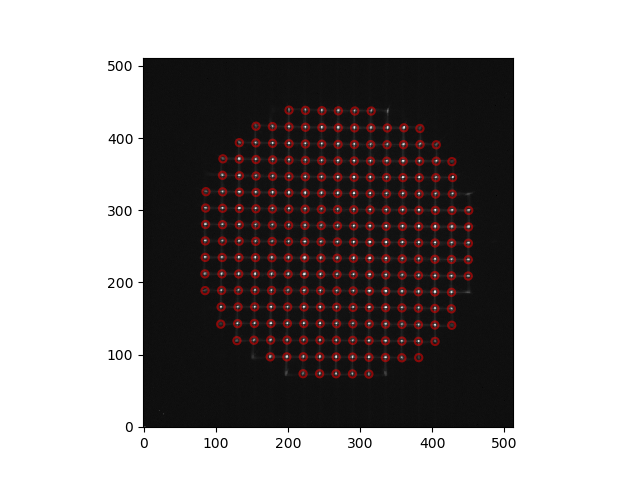

In [15]:
rs = mk_reference("/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera2_ref.fits", yoffset=0.5, plot=True)
plt.show()

In [16]:
np.sqrt(rs['pup_coords'][1]**2 + rs['pup_coords'][0]**2).max()

0.93072419188349298

<IPython.core.display.Javascript object>


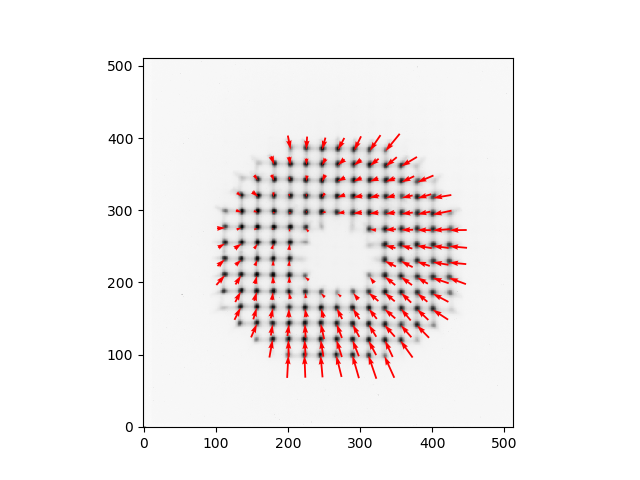

(22.252252252252251, 22.027027027027025)


In [17]:
slopes, aps, spacing, cen, im = get_slopes("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0201.fits", rs, plot=False)
refap = photutils.RectangularAperture(
    (rs['apertures']['xcentroid']+cen[0], rs['apertures']['ycentroid']+cen[1]), 
    w=22,
    h=22, 
    theta=0.0
)
x = aps.positions.transpose()[0]
y = aps.positions.transpose()[1]
u = slopes[0]
v = slopes[1]
norm = visualization.mpl_normalize.ImageNormalize(stretch=visualization.SqrtStretch())
plt.imshow(im, cmap='Greys', origin='lower', norm=norm, interpolation='None')
plt.quiver(x, y, u, v, scale_units='xy', scale=0.2, pivot='tip', color='red')
plt.show()
print(spacing)
#plt.savefig("blah.png")

In [18]:
import opticspy

<IPython.core.display.Javascript object>


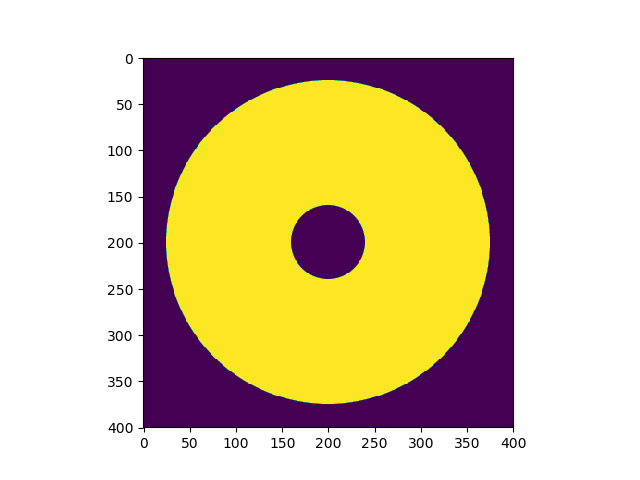

In [19]:
mask = mk_pupil_model()
plt.imshow(mask)
plt.show()

In [20]:
file = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0373.fits"
center = ascii.read("/Users/tim/MMT/shwfs/mmirs2_reference.center")
ref = ascii.read("/Users/tim/MMT/shwfs/mmirs2_sysfile.cntr")
ref1_fits = "/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits"
ref2_fits = "/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera2_ref.fits"
# test images from 20170110: 1, 7, 44, 61, 126, 131-138, 161-168, 183-189, 194-198, 298-299, 327, 369-372
test_fits = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0335.fits"

im = fits.open(file)[0].data
ref1_im = fits.open(ref1_fits)[0].data
ref2_im = fits.open(ref2_fits)[0].data
test = fits.open(test_fits)[0].data

<IPython.core.display.Javascript object>


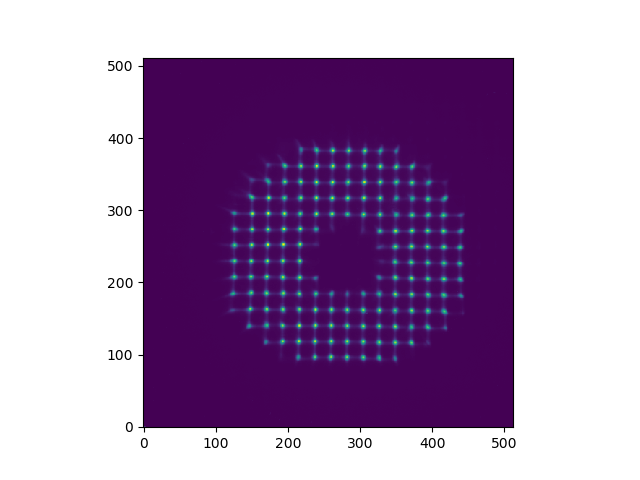

In [21]:
plt.imshow(test, interpolation='nearest', origin='lower')
#plt.scatter(ref['col1'], ref['col2'], color='purple')
#plt.scatter(center['col1'], center['col2'], marker='x', color='white')
#plt.scatter(271, 229, marker='x', color='white')
plt.show()

<IPython.core.display.Javascript object>


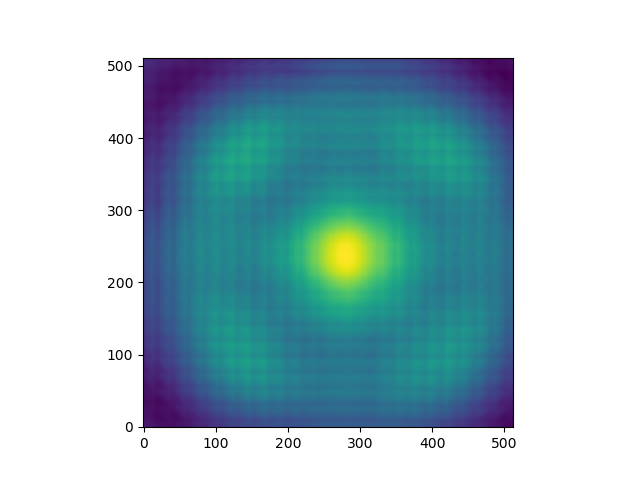

In [22]:
# use skimage.feature.match_template() to do a fast cross-correlation between the WFS image and the pupil model.
# the location of the peak of the correlation will be the center of the WFS pattern.
result = feature.match_template(test, mask, pad_input=True)
plt.imshow(result, interpolation='nearest', origin='lower')
plt.show()

<IPython.core.display.Javascript object>


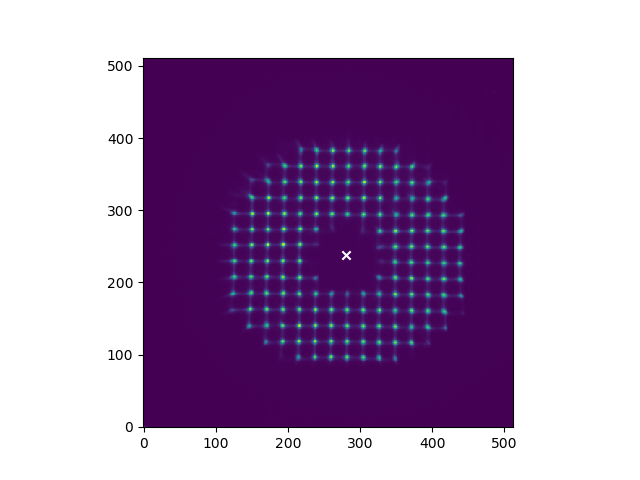

In [23]:
# the correlation image is somewhat complicated, but the peak is distinct as long as there are detectable WFS spots.
# clip the image at 90% of the peak and then do a center-of-mass centroid on it. 
plt.imshow(test, interpolation='nearest', origin='lower')
result[result < 0.9*result.max()] = 0
cen = photutils.centroids.centroid_com(result)
plt.scatter(cen[0], cen[1], marker='x', color='white')
plt.show()

In [24]:
# ndimage and photutils should give the same answer for CoM centroids...
ndimage.center_of_mass(result)

(237.6522189842631, 279.98355777336872)

<IPython.core.display.Javascript object>


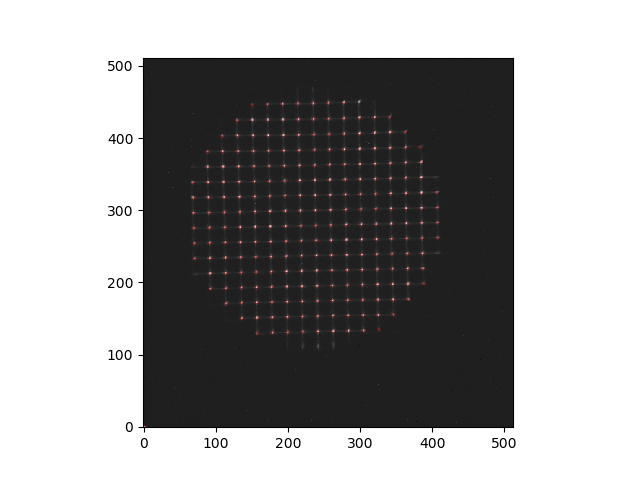

In [25]:
ref_file = "/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits"
ref_data = fits.open(ref_file)[0].data
mean, median, std = stats.sigma_clipped_stats(ref_data, sigma=3.0, iters=5)

daofind = photutils.DAOStarFinder(fwhm=4, threshold=30.0*std)
#starfind = photutils.IRAFStarFinder(fwhm=2.0, threshold=5.0*std)

dao_sources = daofind(ref_data - median)
#iraf_sources = starfind(ref_data - median)

plot_wfsfind(ref_data, dao_sources, ap_radius=0.5)
plt.show()

<IPython.core.display.Javascript object>


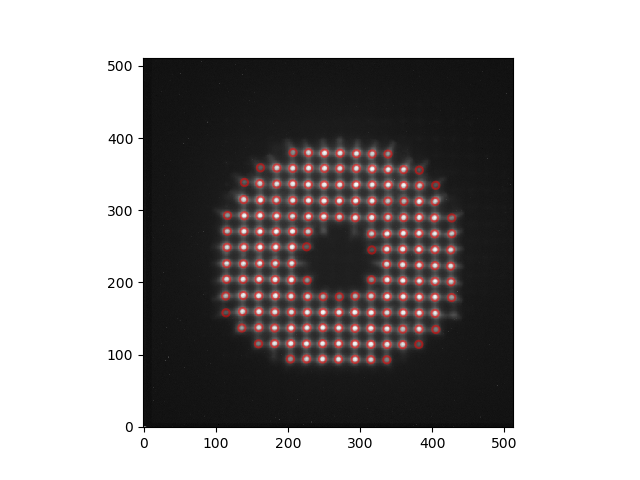

In [26]:
s = wfsfind("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0232.fits", fwhm=7.0, plot=True)
s.sort(['xcentroid'])
plt.show()

<IPython.core.display.Javascript object>


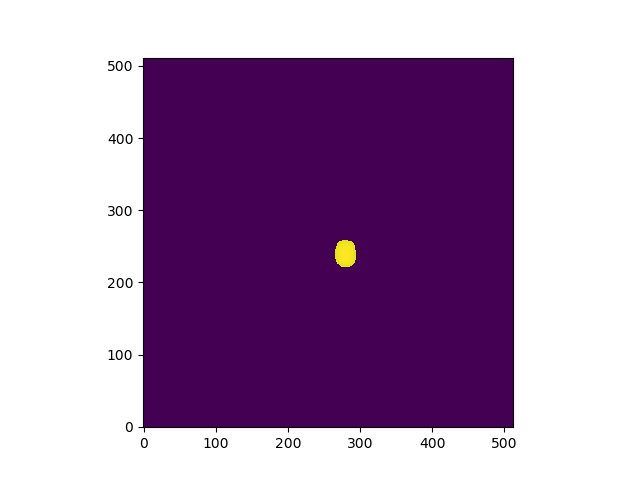

In [32]:
c = center_pupil("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0320.fits", plot=True)
plt.show()

In [ ]:
def fit_wfs_reference(pars, ref, spots):
    xcen = pars[0]
    ycen = pars[1]
    scale = pars[2]
    model = coordinates.SkyCoord(
        representation='cartesian',
        x=scale*ref['xcentroid'] + xcen,
        y=scale*ref['ycentroid'] + ycen,
        z=0.0
    )
    measured = coordinates.SkyCoord(
        representation='cartesian',
        x=spots['xcentroid'],
        y=spots['ycentroid'],
        z=0.0
    )
    idx, ang, dist = coordinates.match_coordinates_3d(measured, model)
    matched_model = ref[idx]
    dist = (spots['xcentroid'] - matched_model['xcentroid'])**2
    dist += (spots['ycentroid'] - matched_model['ycentroid'])**2
    stat = np.sum(dist) / len(idx)**5
    return stat

In [ ]:
from scipy import optimize

In [ ]:
pars = [cen[0], cen[1], 1.0]
xopt = optimize.fmin_powell(fit_wfs_reference, pars, xtol=1e-4, args=(rs, s))

In [ ]:
#data = fits.open("/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits")[0].data
data = fits.open("/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits")[0].data
x = np.sum(data, axis=0)
y = np.sum(data, axis=1)
plt.plot(x)
plt.show()
print(get_mag(data))

In [ ]:
data = fits.open("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0138.fits")[0].data
mean, median, std = stats.sigma_clipped_stats(data, sigma=3.0, iters=5)
data -= median
x = np.sum(data, axis=0)
y = np.sum(data, axis=1)
plt.plot(x)
plt.show()
print(get_mag(data))

In [ ]:
d = np.sum(data, axis=0)
t = np.arange(len(d))
k = np.linspace(5.0, 50., 1000.)
p = stats.LombScargle(t, d).power(1.0/k)
plt.plot(k, p)
plt.show()

In [ ]:
k[p[1:].argmax()+1]

In [ ]:
k[p[10:].argmax()+10]

In [ ]:
k[p.argmax()]

In [ ]:
np.sqrt(22**2 + 22**2)

In [ ]:
pos.swapaxes(1,0)

In [ ]:
pos.transpose()

In [ ]:
3.3541/np.pi

In [ ]:
import opticspy

In [ ]:
Z = opticspy.zernike.Coefficient(Z11=1)
Z.zernikesurface()